In [1]:
import os
%load_ext rpy2.ipython


In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core-rare'

nprocs = 20

In [3]:
%%R
library(ggplot2)
library(phyloseq)
library(tidyr)
library(plyr);library(dplyr)
library(scales)
library(biom)
library(metagenomeSeq)
library(doParallel)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)

physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)
physeq.Bulk = physeq.Bulk %>% filter_taxa(function(x) sum(x) > 0, TRUE) 
physeq.Bulk.Sparsity = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.Bulk.Sparsity

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


In [5]:
%%R
physeq.Bulk.m = physeq.Bulk %>% sample_data

In [6]:
%%R
physeq.Bulk.m$Sample_Date = as.POSIXct(strptime(physeq.Bulk.m$Sample_Date, format = "%m/%d/%y"))
str(physeq.Bulk.m$Sample_Date)

 POSIXct[1:175], format: "2015-11-25" "2014-09-24" "2015-06-17" "2015-10-27" ...


In [7]:
%%R
physeq.Bulk.m$Day = round(difftime(physeq.Bulk.m$Sample_Date, min(physeq.Bulk.m$Sample_Date), 
         units = "days"))
tail(physeq.Bulk.m)

Sample Data:        [6 samples by 25 sample variables]:
                      Full.sample Fraction PrimerF PrimerR Barcode Rev.index
Sept.NTH.2.2015   Sept.NTH.2.2015       NA    515f    806r      28  actcactg
Oct.PTR.3.2015     Oct.PTR.3.2015       NA    515f    806r      55  tagtctcc
Aug.NTR.4.2015     Aug.NTR.4.2015       NA    515f    806r      19  acgctact
Aug.NTH.3.2015     Aug.NTH.3.2015       NA    515f    806r      11  gacatagt
April.NTR.3.2015 April.NTR.3.2015       NA    515f    806r      94  tatagcga
Nov.NTH.4.2015     Nov.NTH.4.2015       NA    515f    806r      81  gtctatga
                 Fwd.index Treatment      Day Replicate Pool Land_Management
Sept.NTH.2.2015   ctgcgtgt      <NA> 440 days         2    8             NTH
Oct.PTR.3.2015    ggatatct      <NA> 474 days         3    8             PTR
Aug.NTR.4.2015    tagcgagt      <NA> 399 days         4    8             NTR
Aug.NTH.3.2015    tagcgagt      <NA> 399 days         3    8             NTH
April.NTR.3.2015  cg

In [8]:
%%R
physeq.Bulk.m$Day_rel = as.numeric(physeq.Bulk.m$Day)


In [9]:
%%R
head(physeq.Bulk.m)


Sample Data:        [6 samples by 26 sample variables]:
                  Full.sample Fraction PrimerF PrimerR Barcode Rev.index
Nov.NTR.4.2015 Nov.NTR.4.2015       NA    515f    806r      84  gtctatga
S.NTR.2               S.NTR.2       NA    515f    806r     145  tagtctcc
June15.NTH.2     June15.NTH.2       NA    515f    806r      84  gtctatga
Oct.NTR.1.2015 Oct.NTR.1.2015       NA    515f    806r      46  ctgcgtag
July.NTR1           July.NTR1       NA    515f    806r     122  actcactg
July.NTR4           July.NTR4       NA    515f    806r     125  actcactg
               Fwd.index Treatment      Day Replicate Pool Land_Management
Nov.NTR.4.2015  ctgcgtgt      <NA> 503 days         4    8             NTR
S.NTR.2         ctactata      <NA>  76 days         2    5             NTR
June15.NTH.2    ctgcgtgt      <NA> 342 days         2    4             NTH
Oct.NTR.1.2015  cgtgagtg      <NA> 474 days         1    8             NTR
July.NTR1       cgttacta      <NA>   0 days         1    5

In [12]:
%%R
physeq.final = merge_phyloseq(physeq.Bulk.Sparsity, physeq.Bulk.m)
physeq.final

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


In [13]:
%%R
physeq.final

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


In [37]:
%%R
make_metagenomeSeq = function(physeq) {
    require("metagenomeSeq")
    require("phyloseq")
    # Enforce orientation
    if (!taxa_are_rows(physeq)) {
        physeq <- t(physeq)
    }
    OTU = as(otu_table(physeq), "matrix")
    #OTUTill = subset(OTU, rownames(OTU) %in% df.Till.r$OTU)

    # Convert sample_data to AnnotatedDataFrame
    ADF = AnnotatedDataFrame(data.frame(sample_data(physeq)))
    # define dummy 'feature' data for OTUs, using their name Helps with
    # extraction and relating to taxonomy later on.
    TDF = AnnotatedDataFrame(data.frame(tax_table(physeq)))
    #TDFTill = subset(TDF, rownames(TDF) %in% df.Till.r$OTU)
    TDF$Rank9 = rownames(TDF)


    # Create the metagenomeSeq object
    MGS = newMRexperiment(counts = OTU, phenoData = ADF, featureData = TDF)
    # Trigger metagenomeSeq to calculate its Cumulative Sum scaling factor.
    MGS = cumNorm(MGS)
    return(MGS)
}

MR = make_metagenomeSeq(physeq.final)

In [38]:
%%R
str(MR)

Formal class 'MRexperiment' [package "metagenomeSeq"] with 8 slots
  ..@ expSummary       :<environment: 0xef490a8> 
  ..@ assayData        :<environment: 0xee3ce38> 
  ..@ phenoData        :Formal class 'AnnotatedDataFrame' [package "Biobase"] with 4 slots
  .. .. ..@ varMetadata      :'data.frame':	26 obs. of  1 variable:
  .. .. .. ..$ labelDescription: chr [1:26] NA NA NA NA ...
  .. .. ..@ data             :'data.frame':	175 obs. of  26 variables:
  .. .. .. ..$ Full.sample    : Factor w/ 175 levels "April15.NTH.1",..: 96 166 66 117 53 56 132 120 17 88 ...
  .. .. .. ..$ Fraction       : int [1:175] NA NA NA NA NA NA NA NA NA NA ...
  .. .. .. ..$ PrimerF        : Factor w/ 1 level "515f": 1 1 1 1 1 1 1 1 1 1 ...
  .. .. .. ..$ PrimerR        : Factor w/ 1 level "806r": 1 1 1 1 1 1 1 1 1 1 ...
  .. .. .. ..$ Barcode        : int [1:175] 84 145 84 46 122 125 159 62 2 181 ...
  .. .. .. ..$ Rev.index      : Factor w/ 12 levels "acgctact","actacgac",..: 8 10 8 6 3 3 5 5 4 8 ...
  .. 

In [39]:
%%R
TimeSeries = function(MR, feature) {  
    
    res = fitTimeSeries(obj = MR, lvl = 'Rank9', feature = feature, class = "OM",
                    id = "Full.sample", time = "Day_rel", log = TRUE)

    return(res)
}




In [14]:
%%R
OTU = as(otu_table(physeq.final), "matrix")

feature = rownames(OTU)
str(feature)

 chr [1:3964] "OTU.1739" "OTU.1813" "OTU.778" "OTU.2180" ...


In [41]:
%%R 
##mdf %>% filter(OTU == 'OTU.99') %>% group_by(Sample_Date) %>% summarise(count = n())

NULL


In [32]:
%%R
feature[3844]

[1] "OTU.25632"


In [15]:
%%R
feature = feature[-67] 

In [16]:
%%R
feature = feature[-3844] 

In [ ]:
%%R
#OTUs not found across all timepoints?
registerDoParallel(20)

TS = llply(feature, 
          TimeSeries, 
          .parallel = TRUE,
          MR = MR 
         )

In [81]:
%%R
str(TS)

List of 3962
 $ OTU.1739 :List of 5
  ..$ timeIntervals: num [1:2, 1:4] 49 364 157 503 -22.1 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:4] "Interval start" "Interval end" "Area" "p.value"
  ..$ data         :'data.frame':	175 obs. of  4 variables:
  .. ..$ abundance: num [1:175] 0 0 1.39 0 0 ...
  .. ..$ class    : Factor w/ 2 levels "H","R": 2 2 1 2 2 2 1 2 1 2 ...
  .. ..$ time     : num [1:175] 503 76 342 474 0 0 111 474 399 139 ...
  .. ..$ id       : Factor w/ 175 levels "April15.NTH.1",..: 96 166 66 117 53 56 132 120 17 88 ...
  ..$ fit          :'data.frame':	504 obs. of  3 variables:
  .. ..$ fit       : num [1:504] -0.247 -0.247 -0.246 -0.246 -0.246 ...
  .. ..$ se        : num [1:504] 0.145 0.145 0.144 0.143 0.142 ...
  .. ..$ timePoints: num [1:504] 0 1 2 3 4 5 6 7 8 9 ...
  ..$ perm         : num [1:1000, 1:2] 10.22 1.24 -11.7 -17.55 10.38 ...
  ..$ call         : language fitTimeSeries(obj = MR, feature = feature, class = "OM", time 

In [296]:
%%R
names(TS) = feature

In [297]:
%%R
timeSeriesFits = sapply(TS,function(i){i[[1]]})[-grep("No",TS)]

In [298]:
%%R
str(timeSeriesFits)

List of 1547
 $ OTU.1739 : num [1:2, 1:4] 49 364 157 503 -22.1 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "Interval start" "Interval end" "Area" "p.value"
 $ OTU.12365: num [1, 1:4] 0 305 -83.004 0.009
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "Interval start" "Interval end" "Area" "p.value"
 $ OTU.2343 : num [1, 1:4] 227 503 -79.7 0
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "Interval start" "Interval end" "Area" "p.value"
 $ OTU.1158 : num [1, 1:4] 425 503 -21.72 0.03
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "Interval start" "Interval end" "Area" "p.value"
 $ OTU.2630 : num [1, 1:4] 0 196 -35.847 0.027
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "Interval start" "Interval end" "Area" "p.value"
 $ OTU.2283 : num [1, 1:4] 122 339 -35.503 0.032
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "Interval start" 

In [299]:
%%R
head(timeSeriesFits[[2]])

     Interval start Interval end      Area p.value
[1,]              0          305 -83.00373   0.009


In [85]:
%%R
for(i in 1:length(timeSeriesFits)){
    rownames(timeSeriesFits[[i]]) =
    paste(
    paste(names(timeSeriesFits)[i]," interval",sep=""),
    1:nrow(timeSeriesFits[[i]]),sep=":"
)
}

In [86]:
%%R
timeSeriesFits = as.data.frame(do.call(rbind, timeSeriesFits))


#do.call(rbind,timeSeriesFits)

In [87]:
%%R
pvalues = timeSeriesFits[,"p.value"]
adjPvalues = p.adjust(pvalues,"bonferroni")
timeSeriesFits = cbind(timeSeriesFits,adjPvalues)
head(timeSeriesFits)

                     Interval start Interval end      Area p.value adjPvalues
OTU.1739 interval:1              49          157 -22.05190   0.024          1
OTU.1739 interval:2             364          503 -27.40846   0.013          1
OTU.12365 interval:1              0          305 -83.00373   0.009          1
OTU.2343 interval:1             227          503 -79.65684   0.000          0
OTU.1158 interval:1             425          503 -21.72335   0.030          1
OTU.2630 interval:1               0          196 -35.84729   0.027          1


In [88]:
%%R
write.csv(timeSeriesFits, 'data/timeSeries_OM.csv')

In [17]:
%%R
TSOM = read.csv('data/timeSeries_OM.csv')

In [18]:
%%R
TS.sig = filter(TSOM, adjPvalues <= 0.01)

In [19]:
%%R
TS.sig$OTU_interval = TS.sig$X
TS.sig = separate(TS.sig, OTU_interval, c('OTU', 'interval'), sep = " ") %>% separate(interval, c('interval', 'num'))
head(TS.sig)

                     X Interval.start Interval.end       Area p.value
1  OTU.2343 interval:1            227          503  -79.65684       0
2  OTU.1547 interval:1            105          170   24.41803       0
3  OTU.3269 interval:1              0          404  147.51265       0
4  OTU.5903 interval:1              0          503  154.53118       0
5 OTU.11057 interval:1              0          415 -146.46944       0
6 OTU.20765 interval:1              0          337  114.21000       0
  adjPvalues       OTU interval num
1          0  OTU.2343 interval   1
2          0  OTU.1547 interval   1
3          0  OTU.3269 interval   1
4          0  OTU.5903 interval   1
5          0 OTU.11057 interval   1
6          0 OTU.20765 interval   1


In [20]:
%%R
print(length(unique(TS.sig$OTU))) 
Mult_resp = TS.sig %>% group_by(OTU) %>% summarise(respTime = n()) %>% filter(respTime > 1)

[1] 357


In [21]:
%%R
Make_DF = function(TS) {  
    
    d = data.frame(TS$data[, c("abundance","class", "time", "id")])
    d$Sample = rownames(TS$data)


    return(d)
}

In [22]:
%%R
l = list()
for (i in 1:length(feature)) {
    classname = as.vector(feature[i])
    l[[classname]] = Make_DF(TS[[i]])
    
}


Error in data.frame(TS$data[, c("abundance", "class", "time", "id")]) : 
  object 'TS' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in data.frame(TS$data[, c("abundance", "class", "time", "id")]) : 
  object 'TS' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In `[<-.factor`(`*tmp*`, ri, value = c(3L, 11L, 6L, 1L, 7L, 7L,  :
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robject

In [10]:
%%R
DF = do.call(rbind, l)

In [11]:
%%R
write.csv(DF, 'data/TimeSeries_Abundance_OM.csv')

In [23]:
%%R
DF = read.csv('data/TimeSeries_Abundance_OM.csv')
head(DF)


Error in read.table(file = file, header = header, sep = sep, quote = quote,  : 
  first five rows are empty: giving up


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in read.table(file = file, header = header, sep = sep, quote = quote,  : 
  first five rows are empty: giving up

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [14]:
%%R
DF2 = tidyr::separate(DF, Class_Sample, c('OTU', "num", "MY", "Treat", 'Rep'), sep = '\\.' )
DF2$C = paste(DF2$OTU, DF2$num, sep = '.')
DF2$Full.sample = paste(DF2$MY, DF2$Treat, DF2$Rep, sep = '.')
DF2 = filter(DF2, C %in% TS.sig$OTU)
head(DF2)


Error in UseMethod("separate_") : 
  no applicable method for 'separate_' applied to an object of class "NULL"


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in UseMethod("separate_") : 
  no applicable method for 'separate_' applied to an object of class "NULL"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [167]:
%%R
head(DF2)
DF.sum = DF2 %>% group_by(C, time, class) %>% summarise(meanab = mean(abundance), sdab = sd(abundance))

In [168]:
%%R
head(DF.sum)

Source: local data frame [6 x 5]
Groups: C, time [3]

      C  time  class   meanab      sdab
  (chr) (int) (fctr)    (dbl)     (dbl)
1 OTU.1     0      H 4.686336 0.9386381
2 OTU.1     0      R 5.192194 0.7002908
3 OTU.1    76      H 4.988630 0.8123174
4 OTU.1    76      R 5.654423 0.8277662
5 OTU.1   111      H 4.702173 0.6252070
6 OTU.1   111      R 5.035940 0.5005345


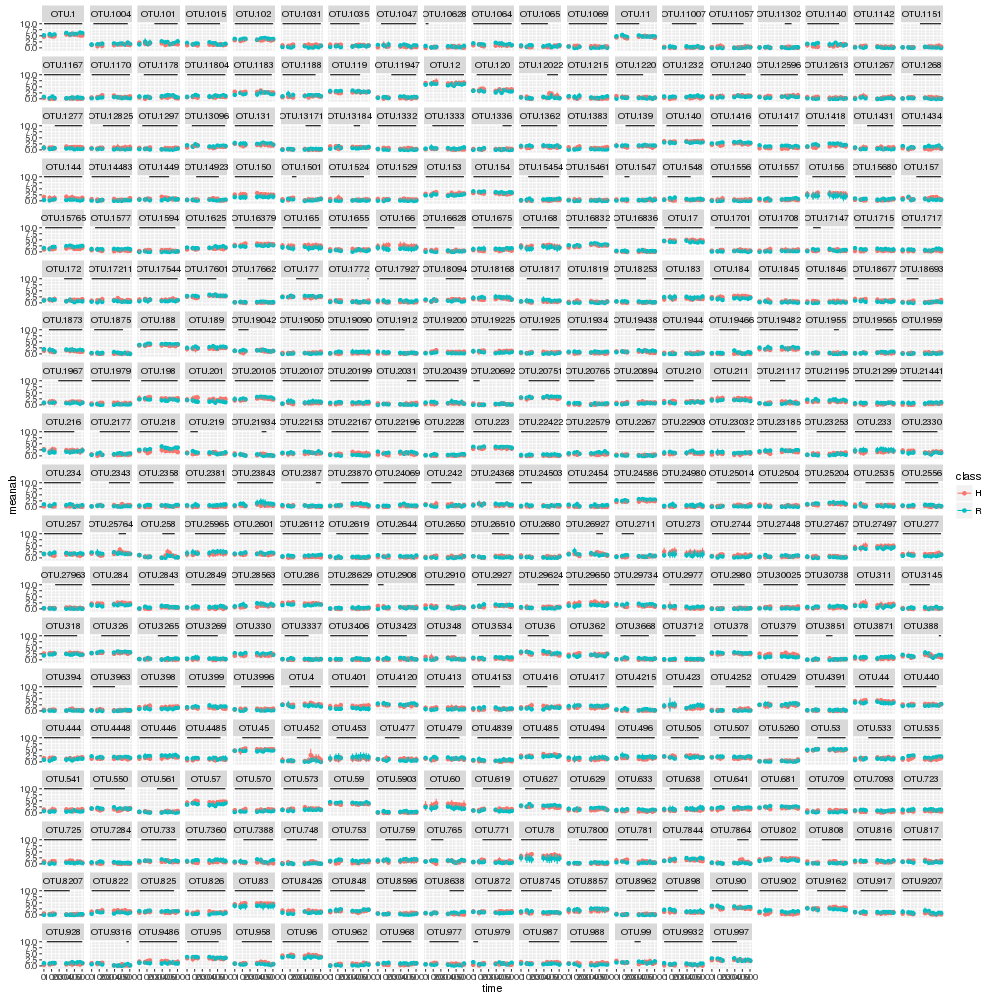

In [105]:
%%R -h 1000 -w 1000
TS.sig$C = TS.sig$OTU

limits = aes(ymax = meanab + sdab, ymin=meanab -sdab, color = class)


ggplot(DF.sum, aes(x = time, y = meanab)) + 
geom_point(aes(color = class)) + 
geom_errorbar(limits, width=0.25)+
geom_segment(data = TS.sig, aes(x = Interval.start, xend = Interval.end, y = 10, yend = 10)) +
facet_wrap(~C)

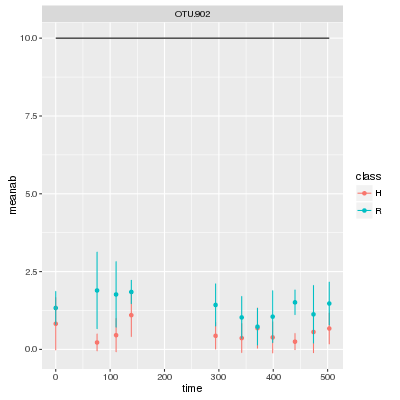

In [328]:
%%R -h 400 -w 400
TS.sig$C = TS.sig$OTU

DF.long = filter(DF.sum, C == 'OTU.902')
TS.long = filter(TS.sig, OTU == 'OTU.902')


limits = aes(ymax = meanab + sdab, ymin=meanab -sdab, color = class)


ggplot(DF.long, aes(x = time, y = meanab)) + 
geom_point(aes(color = class)) + 
geom_errorbar(limits, width=0.25)+
geom_segment(data = TS.long, aes(x = Interval.start, xend = Interval.end, y = 10, yend = 10)) +
facet_wrap(~C)

In [326]:
%%R
(TS.sig) %>% arrange(-Area) %>% head

                    X Interval.start Interval.end     Area p.value adjPvalues
1  OTU.218 interval:1              0          503 488.2584       0          0
2  OTU.902 interval:1              0          503 432.5305       0          0
3  OTU.535 interval:1              0          503 393.6211       0          0
4  OTU.233 interval:1              0          488 368.0042       0          0
5 OTU.1417 interval:1              0          503 358.2709       0          0
6  OTU.496 interval:1              0          503 349.7413       0          0
       OTU interval num    Start     End        C
1  OTU.218 interval   1 July2014 Nov2015  OTU.218
2  OTU.902 interval   1 July2014 Nov2015  OTU.902
3  OTU.535 interval   1 July2014 Nov2015  OTU.535
4  OTU.233 interval   1 July2014 Oct2015  OTU.233
5 OTU.1417 interval   1 July2014 Nov2015 OTU.1417
6  OTU.496 interval   1 July2014 Nov2015  OTU.496


In [36]:
%%R -w 1200 -h 500

Mult_TS$ISIE = factor(Mult_TS$ISIE, levels = Mult_TS$ISIE[order(-Mult_TS_sum$counts)])


ggplot(Mult_TS, aes(x = ISIE)) + geom_bar(aes(fill = as.factor(TS_num))) + #+ facet_wrap(~TS_num)+
        theme(text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))  + xlab('Time Period')+
        ylab('Number of OTUs') 



Error in factor(Mult_TS$ISIE, levels = Mult_TS$ISIE[order(-Mult_TS_sum$counts)]) : 
  object 'Mult_TS' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in factor(Mult_TS$ISIE, levels = Mult_TS$ISIE[order(-Mult_TS_sum$counts)]) : 
  object 'Mult_TS' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [37]:
%%R
head(TS.sig)
TS.sig$Start[TS.sig$Interval.start %in% c(0:75)] = 'July2014'
#TS.sig$Start[TS.sig$Interval.start > 0 & TS.sig$Interval.start <76] = 'JunetoSept_2014'
TS.sig$Start[TS.sig$Interval.start %in% c(76:110)] = 'September2014'
#TS.sig$Start[TS.sig$Interval.start > 76 & TS.sig$Interval.start < 111 ] = 'SepttoOct_2014'
TS.sig$Start[TS.sig$Interval.start %in% c(111:138)] = 'October2014'
#TS.sig$Start[TS.sig$Interval.start > 111 & TS.sig$Interval.start < 139 ] = 'Oct_Nov_2014'
TS.sig$Start[TS.sig$Interval.start == 139] = 'November2014'
TS.sig$Start[TS.sig$Interval.start > 139 & TS.sig$Interval.start < 294] = 'Nov2014April2015'
TS.sig$Start[TS.sig$Interval.start %in% c(294:341)] = 'April2015'
#TS.sig$Start[TS.sig$Interval.start > 294 & TS.sig$Interval.start < 342] = 'April_June_2015'
TS.sig$Start[TS.sig$Interval.start %in% c(342: 370)] = 'June2015'
#TS.sig$Start[TS.sig$Interval.start > 342 & TS.sig$Interval.start < 371] = 'June_July_2015'
TS.sig$Start[TS.sig$Interval.start %in% c(371: 398)] = 'July2015'
#TS.sig$Start[TS.sig$Interval.start > 371 & TS.sig$Interval.start < 399] = 'July_Aug_2015'
TS.sig$Start[TS.sig$Interval.start %in% c(399: 439)] = 'August2015'
#TS.sig$Start[TS.sig$Interval.start > 399 & TS.sig$Interval.start < 440] = 'Aug_Sept_2015'
TS.sig$Start[TS.sig$Interval.start %in% c(440: 473)] = 'Sept2015'
#TS.sig$Start[TS.sig$Interval.start > 440 & TS.sig$Interval.start < 474] = 'Sept_Oct_2015'
TS.sig$Start[TS.sig$Interval.start %in% c(474: 502)] = 'Oct2015'
#TS.sig$Start[TS.sig$Interval.start > 474 & TS.sig$Interval.start < 503] = 'Oct_Nov_2015'
TS.sig$Start[TS.sig$Interval.start == 503] = 'Nov2015'


TS.sig$End[TS.sig$Interval.end %in% c(0:75)] = 'July2014'
#TS.sig$End[TS.sig$Interval.end > 0 & TS.sig$Interval.end <76] = 'JunetoSept_2014'
TS.sig$End[TS.sig$Interval.end %in% c(76:110)] = 'September2014'
#TS.sig$End[TS.sig$Interval.end > 76 & TS.sig$Interval.end < 111 ] = 'SepttoOct_2014'
TS.sig$End[TS.sig$Interval.end %in% c(111:138)] = 'October2014'
#TS.sig$End[TS.sig$Interval.end > 111 & TS.sig$Interval.end < 139 ] = 'Oct_Nov_2014'
TS.sig$End[TS.sig$Interval.end == 139] = 'November2014'
TS.sig$End[TS.sig$Interval.end > 139 & TS.sig$Interval.end < 294] = 'Nov2014_April2015'
TS.sig$End[TS.sig$Interval.end %in% c(294:341)] = 'April2015'
#TS.sig$End[TS.sig$Interval.end > 294 & TS.sig$Interval.end < 342] = 'April_June_2015'
TS.sig$End[TS.sig$Interval.end %in% c(342: 370)] = 'June2015'
#TS.sig$End[TS.sig$Interval.end > 342 & TS.sig$Interval.end < 371] = 'June_July_2015'
TS.sig$End[TS.sig$Interval.end %in% c(371: 398)] = 'July2015'
#TS.sig$Start[TS.sig$Interval.end > 371 & TS.sig$Interval.end < 399] = 'July_Aug_2015'
TS.sig$End[TS.sig$Interval.end %in% c(399: 439)] = 'August2015'
#TS.sig$End[TS.sig$Interval.end > 399 & TS.sig$Interval.end < 440] = 'Aug_Sept_2015'
TS.sig$End[TS.sig$Interval.end %in% c(440: 473)] = 'Sept2015'
#TS.sig$End[TS.sig$Interval.end > 440 & TS.sig$Interval.end < 474] = 'Sept_Oct_2015'
TS.sig$End[TS.sig$Interval.end %in% c(474: 502)] = 'Oct2015'
#TS.sig$End[TS.sig$Interval.end > 474 & TS.sig$Interval.end < 503] = 'Oct_Nov_2015'
TS.sig$End[TS.sig$Interval.end == 503] = 'Nov2015'





In [38]:
%%R
Mult_TS = TS.sig %>% group_by(OTU) %>% mutate(TS_num = n()) %>% mutate(diff = Interval.end-Interval.start)

head(Mult_TS) %>% as.data.frame

                     X Interval.start Interval.end       Area p.value
1  OTU.2343 interval:1            227          503  -79.65684       0
2  OTU.1547 interval:1            105          170   24.41803       0
3  OTU.3269 interval:1              0          404  147.51265       0
4  OTU.5903 interval:1              0          503  154.53118       0
5 OTU.11057 interval:1              0          415 -146.46944       0
6 OTU.20765 interval:1              0          337  114.21000       0
  adjPvalues       OTU interval num            Start               End TS_num
1          0  OTU.2343 interval   1 Nov2014April2015           Nov2015      1
2          0  OTU.1547 interval   1    September2014 Nov2014_April2015      1
3          0  OTU.3269 interval   1         July2014        August2015      1
4          0  OTU.5903 interval   1         July2014           Nov2015      1
5          0 OTU.11057 interval   1         July2014        August2015      1
6          0 OTU.20765 interval   1       

In [39]:
%%R
Mult_TS$ISIE = paste(Mult_TS$Start, Mult_TS$End, sep = '-')

In [40]:
%%R
Mult_TS_sum = Mult_TS %>% group_by(ISIE) %>% summarise(counts = n(), max_diff = max(diff), min_diff = min(diff))

In [41]:
%%R
Mult_TS$type = ifelse(Mult_TS$diff > 392, 'Long Term',
                      ifelse(Mult_TS$diff %in% c(210: 392), 'Extended',
                            ifelse(Mult_TS$diff %in% c(103: 209), 'Interannual',
                                ifelse(Mult_TS$diff %in% c(30:102), 'Seasonal','Short term'))))

In [42]:
%%R
Mult_TS %>% group_by(type) %>% filter(Area > 0) %>% summarize(nR = n()) %>% print()
Mult_TS %>% group_by(type) %>% filter(Area < 0) %>% summarize(nH = n()) %>% print

Source: local data frame [4 x 2]

         type    nR
        (chr) (int)
1    Extended    35
2 Interannual     6
3   Long Term   140
4    Seasonal     9
Source: local data frame [5 x 2]

         type    nH
        (chr) (int)
1    Extended    42
2 Interannual     7
3   Long Term   107
4    Seasonal    10
5  Short term     1


In [43]:
%%R
tax = as.data.frame(tax_table(physeq.Bulk.Sparsity))
tax$OTU = rownames(tax)
head(tax)

             Rank1            Rank2          Rank3                  Rank4 Rank5
OTU.1739  Bacteria __Planctomycetes        __OM190 __uncultured_bacterium  <NA>
OTU.1813  Bacteria __Planctomycetes        __OM190 __uncultured_bacterium  <NA>
OTU.778   Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
OTU.2180  Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
OTU.12365 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
OTU.2343  Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
          Rank6 Rank7 Rank8       OTU
OTU.1739   <NA>  <NA>  <NA>  OTU.1739
OTU.1813   <NA>  <NA>  <NA>  OTU.1813
OTU.778    <NA>  <NA>  <NA>   OTU.778
OTU.2180   <NA>  <NA>  <NA>  OTU.2180
OTU.12365  <NA>  <NA>  <NA> OTU.12365
OTU.2343   <NA>  <NA>  <NA>  OTU.2343


In [44]:
%%R
tax$Rank2 = gsub("__", "", tax$Rank2)
tax$Rank3 = gsub("__", "", tax$Rank3)
tax$Rank4 = gsub("__", "", tax$Rank4)
tax$Rank5 = gsub("__", "", tax$Rank5)
tax$Rank6 = gsub("__", "", tax$Rank6)
tax$Rank7 = gsub('__', "", tax$Rank7)

In [45]:
%%R
Mult_TS_tax = left_join(Mult_TS, tax, by = "OTU")

In [46]:
%%R
Mult_TS_sum_type = Mult_TS_tax %>% group_by(type, Rank2, ISIE) %>%
        summarise(counts = n(), max_diff = max(diff), min_diff = min(diff))

In [48]:
%%R
cols = c("#DE3565",
"#64C036",
"#CA6ED8",
"#B7B938",
"#6F81DD",
"#CE8E2E",
"#528FB8",
"#DD502D",
"#3EBEBD",
"#D44D9C",
"#59C171",
"#AF699B",
"#6E7F27",
"#9781BE",
"#3E814F",
"#C75B6F",
"#BA6040")

In [47]:
%%R
(Mult_TS_sum_type) %>% group_by(type) %>% summarise(num = sum(counts))

Source: local data frame [5 x 2]

         type   num
        (chr) (int)
1    Extended    77
2 Interannual    13
3   Long Term   247
4    Seasonal    19
5  Short term     1


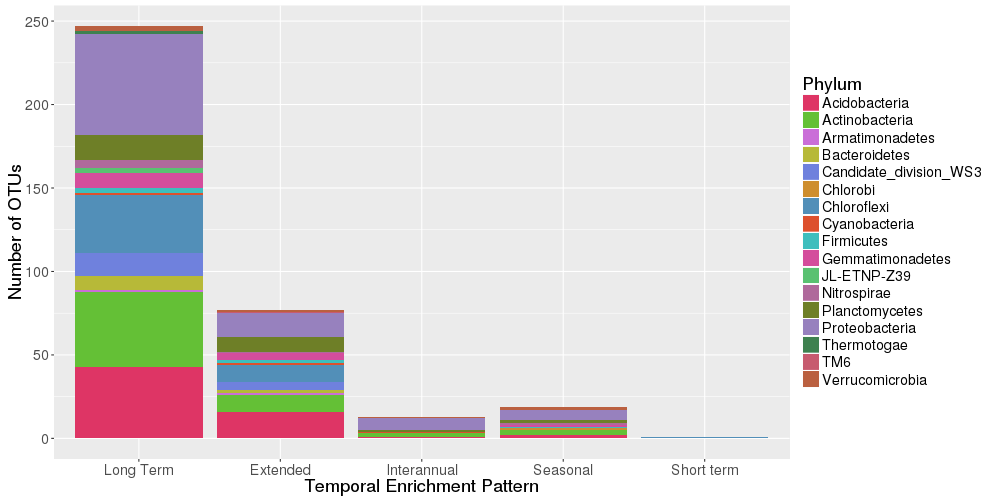

In [51]:
%%R -w 1000 -h 500


Mult_TS_sum_type$type = factor(Mult_TS_sum_type$type, levels = Mult_TS_sum_type$type[order(-Mult_TS_sum_type$counts)])

p = ggplot(data = Mult_TS_sum_type, aes(type, counts, fill = Rank2)) + geom_bar(stat='identity') +
        theme(text = element_text(size=18), axis.text.x = element_text(angle=0, vjust=1))  + 
        xlab('Temporal Enrichment Pattern') + ylab('Number of OTUs') + scale_fill_manual(values = cols, name = 'Phylum')

p

In [54]:
%%R
ggsave('data/figs/TemporalEnrichment_OM.png', p, width=10, height=6)


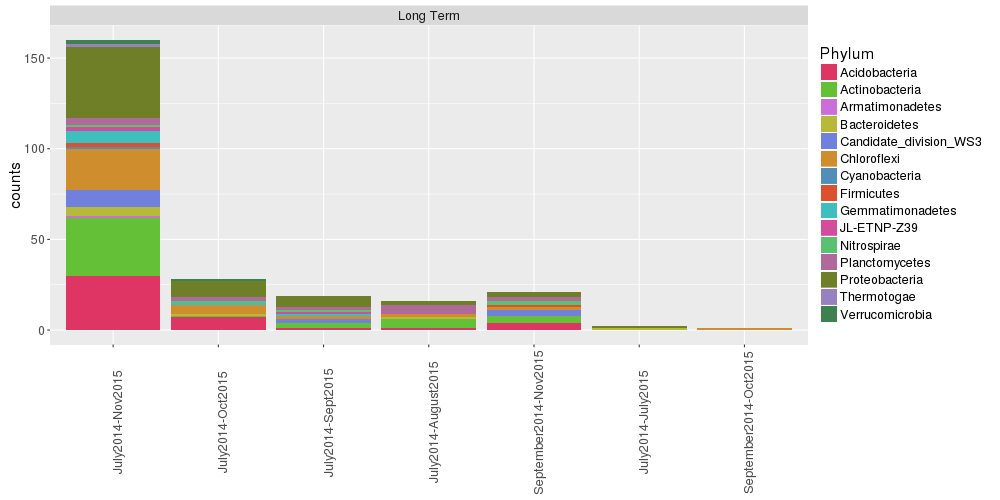

In [50]:
%%R -w 1000 -h 500

Longterm = filter(Mult_TS_sum_type, type == 'Long Term')%>% group_by(ISIE, type, Rank2) %>%
    summarise(counts = sum(counts)) 
Longterm$ISIE = factor(Longterm$ISIE, levels = Longterm$ISIE[order(-Longterm$counts)])

p = ggplot(data = Longterm, aes(ISIE, counts, fill = Rank2)) + geom_bar(stat='identity') +
        theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) + facet_wrap(~type) +
        scale_fill_manual(values = cols, name = "Phylum")  + xlab(NULL) 

p

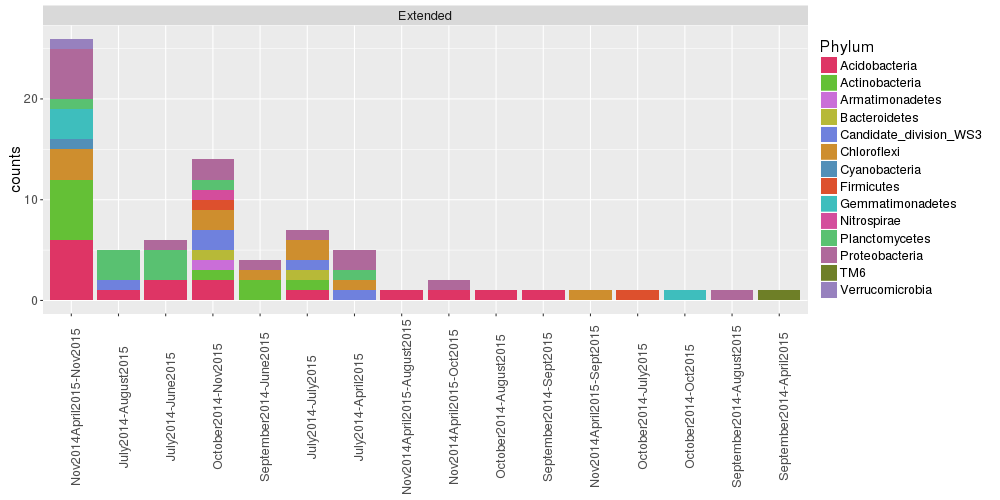

In [311]:
%%R -w 1000 -h 500

Mult_TS_sum_type$ISIE = factor(Mult_TS_sum_type$ISIE, levels = Mult_TS_sum_type$ISIE[order(-Mult_TS_sum_type$counts)])

Longterm = filter(Mult_TS_sum_type, type == 'Extended')  %>% group_by(ISIE, type, Rank2) %>%
    summarise(counts = sum(counts)) 
Longterm$ISIE = factor(Longterm$ISIE, levels = Longterm$ISIE[order(-Longterm$counts)])

p = ggplot(data = Longterm, aes(ISIE, counts, fill = Rank2)) + geom_bar(stat='identity') +
        theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) + facet_wrap(~type)+
        scale_fill_manual(values = cols, name = "Phylum")   + xlab(NULL)


p

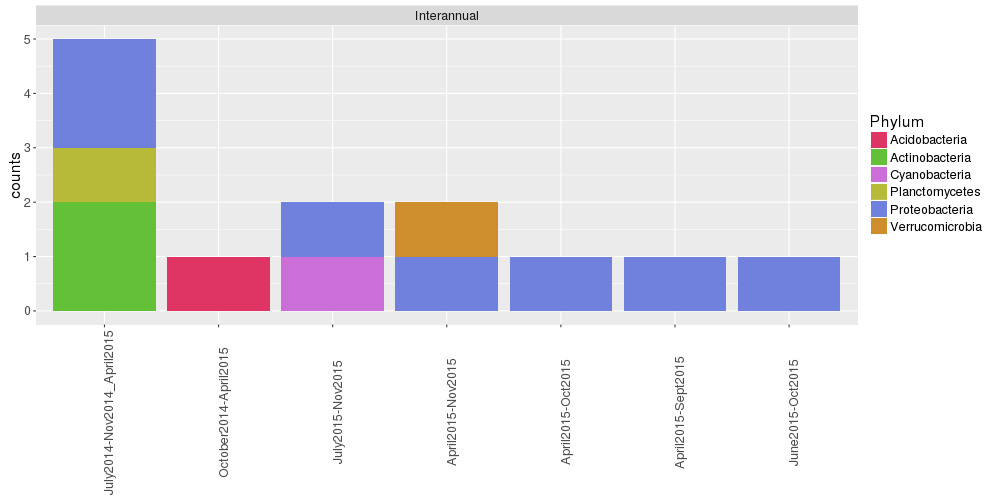

In [310]:
%%R -w 1000 -h 500


Longterm = filter(Mult_TS_sum_type, type == 'Interannual') %>% group_by(ISIE, type, Rank2) %>%
    summarise(counts = sum(counts)) 
Longterm$ISIE = factor(Longterm$ISIE, levels = Longterm$ISIE[order(-Longterm$counts)])

p = ggplot(data = Longterm, aes(ISIE, counts, fill = Rank2)) + geom_bar(stat='identity') +
        theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) + facet_wrap(~type)+
        scale_fill_manual(values = cols, name = "Phylum") + xlab(NULL)


p

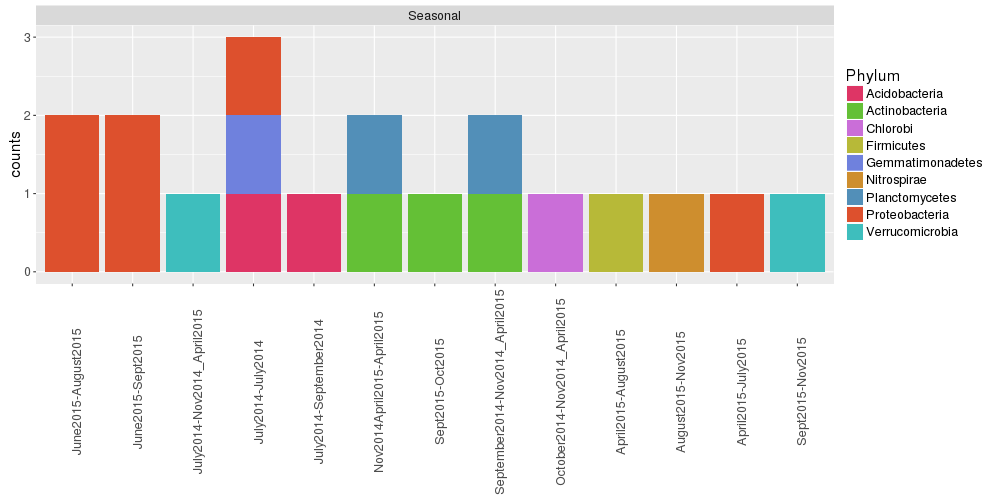

In [309]:
%%R -w 1000 -h 500


Longterm = filter(Mult_TS_sum_type, type == 'Seasonal') %>% group_by(ISIE, type, Rank2) %>%
    summarise(counts = sum(counts)) 
Longterm$ISIE = factor(Longterm$ISIE, levels = Longterm$ISIE[order(-Longterm$counts)])

p = ggplot(data = Longterm, aes(ISIE, counts, fill = Rank2)) + geom_bar(stat='identity') +
        theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) + facet_wrap(~type)+
        scale_fill_manual(values = cols, name = "Phylum") + xlab(NULL)


p

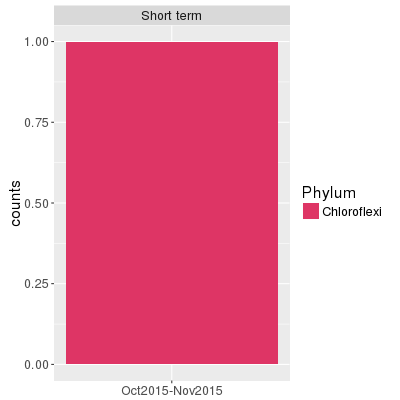

In [308]:
%%R -w 400 -h 400

Mult_TS_sum_type$ISIE = factor(Mult_TS_sum_type$ISIE, levels = Mult_TS_sum_type$ISIE[order(-Mult_TS_sum_type$counts)])

Longterm = filter(Mult_TS_sum_type, type == 'Short term')%>% group_by(ISIE, type, Rank2) %>%
    summarise(counts = sum(counts)) 
Longterm$ISIE = factor(Longterm$ISIE, levels = Longterm$ISIE[order(-Longterm$counts)])

p = ggplot(data = Longterm, aes(ISIE, counts, fill = Rank2)) + geom_bar(stat='identity') +
        theme(text = element_text(size=16), axis.text.x = element_text(angle=0, vjust=1)) + facet_wrap(~type)+
        scale_fill_manual(values = cols, name = "Phylum") + xlab(NULL)


p

In [115]:
%%R
head(Mult_TS) %>% as.data.frame()
o = filter(Mult_TS, TS_num == 1)
one = filter(diff, OTU %in% o$OTU)

In [116]:
%%R
one$Start_stop = paste(one$Start, one$End, sep = '__')
head(one)

                     X Interval.start Interval.end       Area p.value
1  OTU.2343 interval:1            227          503  -79.65684       0
2  OTU.1547 interval:1            105          170   24.41803       0
3  OTU.3269 interval:1              0          404  147.51265       0
4  OTU.5903 interval:1              0          503  154.53118       0
5 OTU.11057 interval:1              0          415 -146.46944       0
6 OTU.20765 interval:1              0          337  114.21000       0
  adjPvalues       OTU interval num    ISIE         C             Start
1          0  OTU.2343 interval   1 227_503  OTU.2343 Nov2014_April2015
2          0  OTU.1547 interval   1 105_170  OTU.1547    SepttoOct_2014
3          0  OTU.3269 interval   1   0_404  OTU.3269         June_2014
4          0  OTU.5903 interval   1   0_503  OTU.5903         June_2014
5          0 OTU.11057 interval   1   0_415 OTU.11057         June_2014
6          0 OTU.20765 interval   1   0_337 OTU.20765         June_2014
      

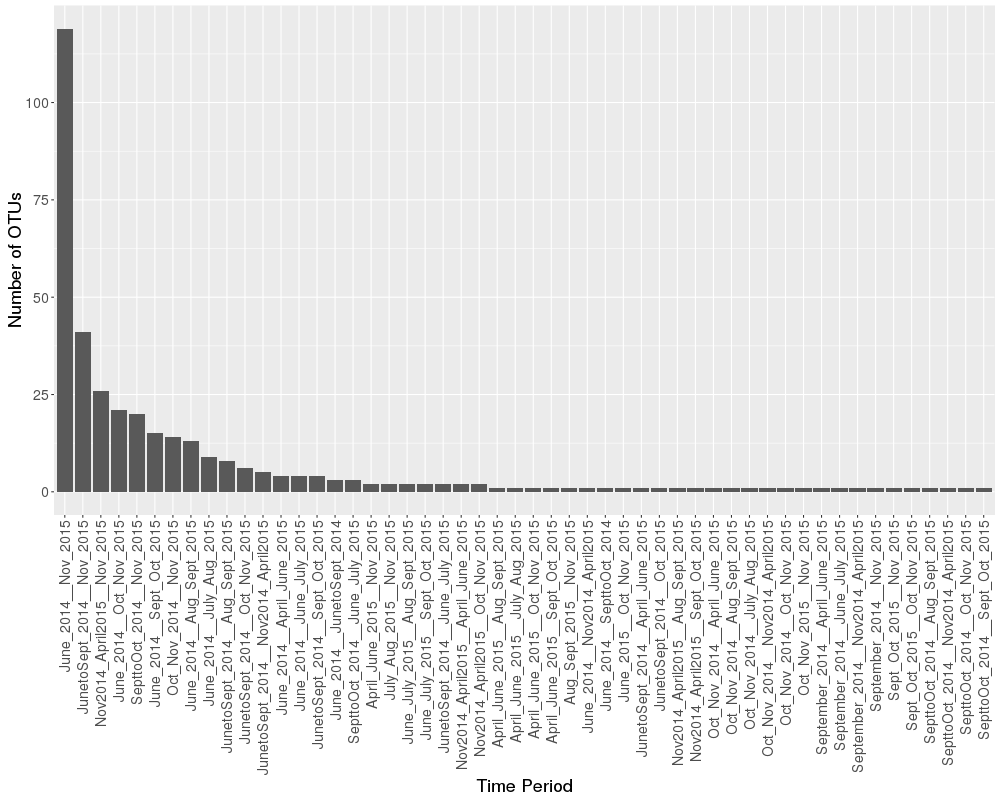

In [117]:
%%R -h 800 -w 1000
plot = one %>% group_by(Start_stop) %>% summarise(counts = n())
plot$Start_stop = factor(plot$Start_stop, levels = plot$Start_stop[order(-plot$counts)])

ggplot(data = plot, aes(x = Start_stop, y = counts)) + geom_bar(stat = 'identity') +
        theme(text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))  + xlab('Time Period')+
        ylab('Number of OTUs') 

In [118]:
%%R
head(one)

                     X Interval.start Interval.end       Area p.value
1  OTU.2343 interval:1            227          503  -79.65684       0
2  OTU.1547 interval:1            105          170   24.41803       0
3  OTU.3269 interval:1              0          404  147.51265       0
4  OTU.5903 interval:1              0          503  154.53118       0
5 OTU.11057 interval:1              0          415 -146.46944       0
6 OTU.20765 interval:1              0          337  114.21000       0
  adjPvalues       OTU interval num    ISIE         C             Start
1          0  OTU.2343 interval   1 227_503  OTU.2343 Nov2014_April2015
2          0  OTU.1547 interval   1 105_170  OTU.1547    SepttoOct_2014
3          0  OTU.3269 interval   1   0_404  OTU.3269         June_2014
4          0  OTU.5903 interval   1   0_503  OTU.5903         June_2014
5          0 OTU.11057 interval   1   0_415 OTU.11057         June_2014
6          0 OTU.20765 interval   1   0_337 OTU.20765         June_2014
      

In [120]:
%%R
head(one)

one %>% filter(diff >=503) %>% summarise(totallyconsistent = n()) %>% print()
one %>% filter(diff >=384) %>% summarise(longterm = n()) %>% print()
one %>% filter(diff >=35 & diff <=76) %>% summarise(shortterm = n()) %>% print()
one %>% filter(diff <35) %>% summarise(month = n()) %>% print()
one %>% filter(diff >35 & diff <= 120) %>% summarise(medium = n()) %>% print()
one %>% filter(diff >120 & diff < 400) %>% summarise(medium = n()) %>% print()

  totallyconsistent
1               119
  longterm
1      253
  shortterm
1         8
  month
1     3
  medium
1     18
  medium
1     94


In [125]:
%%R
med = one %>% filter(diff >35 & diff <= 120) 
head(med)


                     X Interval.start Interval.end      Area p.value adjPvalues
1  OTU.1547 interval:1            105          170  24.41803       0          0
2    OTU.99 interval:1            237          318  58.76748       0          0
3  OTU.2387 interval:1            437          503  18.11479       0          0
4 OTU.11302 interval:1            330          420 -20.30344       0          0
5 OTU.10628 interval:1              0           38  20.86459       0          0
6  OTU.1501 interval:1            124          183 -31.47391       0          0
        OTU interval num    ISIE         C             Start               End
1  OTU.1547 interval   1 105_170  OTU.1547    SepttoOct_2014 Nov2014_April2015
2    OTU.99 interval   1 237_318    OTU.99 Nov2014_April2015   April_June_2015
3  OTU.2387 interval   1 437_503  OTU.2387     Aug_Sept_2015          Nov_2015
4 OTU.11302 interval   1 330_420 OTU.11302   April_June_2015     Aug_Sept_2015
5 OTU.10628 interval   1    0_38 OTU.10628   

In [132]:
%%R
NTR.bulk = read.csv('data/NTR_ApNov_Enriched.csv')
med.ab = filter(DF.sum, C %in% NTR.bulk$OTU)
med.sig = filter(TS.sig, C %in% NTR.bulk$OTU)

In [136]:
%%R
length(unique(NTR.bulk$OTU))

[1] 24


In [143]:
%%R
head(TSOM)

                     X Interval.start Interval.end      Area p.value adjPvalues
1  OTU.1739 interval:1             49          157 -22.05190   0.024          1
2  OTU.1739 interval:2            364          503 -27.40846   0.013          1
3 OTU.12365 interval:1              0          305 -83.00373   0.009          1
4  OTU.2343 interval:1            227          503 -79.65684   0.000          0
5  OTU.1158 interval:1            425          503 -21.72335   0.030          1
6  OTU.2630 interval:1              0          196 -35.84729   0.027          1


In [145]:
%%R
filter(TSOM, X == 'OTU.10 interval:1')

                  X Interval.start Interval.end     Area p.value adjPvalues
1 OTU.10 interval:1            109          366 116.7258   0.061          1


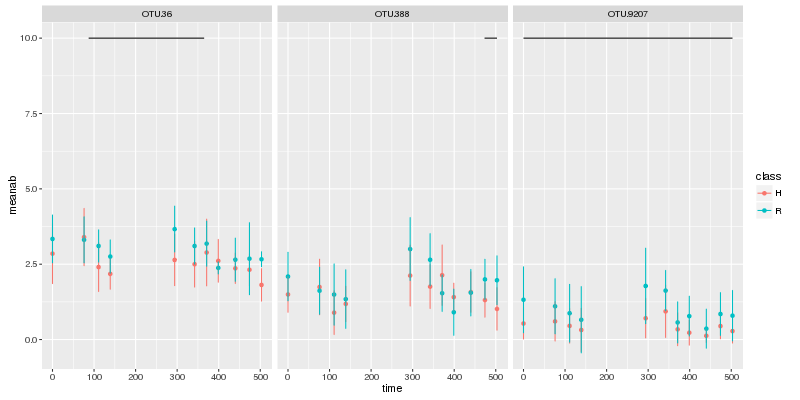

In [138]:
%%R -h 400 -w 800

limits = aes(ymax = meanab + sdab, ymin=meanab -sdab, color = class)

ggplot(med.ab, aes(x = time, y = meanab)) + 
geom_point(aes(color = class)) + 
geom_errorbar(limits, width=0.25)+
geom_segment(data = med.sig, aes(x = Interval.start, xend = Interval.end, y = 10, yend = 10)) +
facet_wrap(~C)

In [284]:
%%R
head(med.ab)

Source: local data frame [6 x 5]
Groups: C, time [3]

       C  time  class   meanab      sdab
   (chr) (dbl) (fctr)    (dbl)     (dbl)
1 OTU.36     0      H 2.851294 1.0050508
2 OTU.36     0      R 3.339944 0.8040070
3 OTU.36    76      H 3.399471 0.9617245
4 OTU.36    76      R 3.308872 0.7728447
5 OTU.36   111      H 2.405590 0.8233074
6 OTU.36   111      R 3.105636 0.5451773


In [121]:
%%R
test = one %>% filter(diff >=384, Area >0) %>% summarise(.resp = n()) %>% print
test = one %>% filter(diff >=384, Area <0) %>% summarise(NT.resp = n()) %>% print

  PT.resp
1     144
  NT.resp
1     109


In [123]:
%%R
sessionInfo()

R version 3.2.4 Revised (2016-03-16 r70336)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu precise (12.04.5 LTS)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] doParallel_1.0.10     iterators_1.0.8       metagenomeSeq_1.11.10
 [4] RColorBrewer_1.1-2    glmnet_2.0-3          foreach_1.4.3        
 [7] Matrix_1.2-4          limma_3.22.7          Biobase_2.30.0       
[10] BiocGenerics_0.16.1   biom_0.3.12           scales_0.4.0         
[13] dplyr_0.4.3           plyr_1.8.3            tidyr_0.4.1          
[16] p

## Sandbox

In [ ]:
%%R
Make_DF = function(TS) {  
    
    d = data.frame(TS$data[, c("abundance","class", "time", "id")])
    d$Sample = rownames(TS$data)


    return(d)
}

In [ ]:
%%R
l = list()
for (i in 1:length(feature)) {
    classname = as.vector(feature[i])
    l[[classname]] = Make_DF(TS[[i]])
    
}

In [ ]:
%%R
DF = do.call(rbind, l)

In [ ]:
%%R
DF$Class_Sample = rownames(DF)

In [ ]:
%%R
head(DF)

In [ ]:
%%R
unique(DF$time)

In [ ]:
%%R
DF2 = separate(DF, Class_Sample, c('OTU', "num", "MY", "Treat", 'Rep'), sep = '\\.' )
DF2$C = paste(DF2$OTU, DF2$num, sep = '.')
DF2$Full.sample = paste(DF2$MY, DF2$Treat, DF2$Rep, sep = '.')
head(DF2)


In [ ]:
%%R
length(unique(DF2$Rep))

In [ ]:
%%R
Make_DF2 = function(TS) {  
    
    d = data.frame(TS$timeIntervals)


    return(d)
}

In [ ]:
%%R
l.pval = list()
for (i in 1:length(feature)) {
    classname = as.character(feature[i])
    l.pval[[classname]] = Make_DF2(TS[[i]])
    
}

In [ ]:
%%R
l.pval2 = list()


for (i in 1:length(l.pval)) {
        if (length(l.pval[[i]]) == 1) {
        l.pval2[[i]] = l.pval[[i]]
        l.pval2[[i]]$Interval.start = NA
        l.pval2[[i]]$Interval.end = NA
        l.pval2[[i]]$Area = NA
        l.pval2[[i]]$p.value = NA
        l.pval2[[i]]$TS.timeIntervals = NULL
    } else {
            l.pval2[[i]] = l.pval[[i]]
        } 
    
}

In [ ]:
%%R

l.pval3 = list()
for (i in 1:length(feature)) {
    classname = as.character(feature[i])
    l.pval3[[classname]] = l.pval2[[i]]
    
}

In [ ]:
%%R
DF3 = do.call(rbind, l.pval3)

In [ ]:
%%R
DF3$C = rownames(DF3)
head(DF3)


In [ ]:
%%R
head(DF2)
df.total = left_join(DF2, DF3)

In [ ]:
%%R
head(df.total)

In [ ]:
%%R
length(unique(df.total$C))

In [ ]:
%%R
Make_DF3 = function(TS) {  
    
    d = data.frame(TS$fit[, c("fit","se", "timePoints")])
    d$Sample = rownames(TS$fit)


    return(d)
}

In [ ]:
%%R

l2 = list()
for (i in 1:length(feature)) {
    classname = as.vector(feature[i])
    l2[[classname]] = Make_DF3(TS[[i]])
    
}

In [ ]:
%%R
fit = do.call(rbind, l2)

In [ ]:
%%R
head(fit)

In [ ]:
%%R
require(tidyr)
fit$C = rownames(fit)
fit$time = fit$timePoints
fit$timePoints = NULL

In [ ]:
%%R
fit2 = fit %>% separate(C, c("OTU", 'num', 'extra'), sep = '\\.')
fit2$C = paste(fit2$OTU, fit2$num, sep ='.')
fit2$OTU = NULL
fit2$num = NULL
fit2$extra = NULL
head(fit2)

In [ ]:
%%R
df.all = left_join(df.total, fit2, by = c('time', 'C'))

In [ ]:
%%R
head(df.all)

In [ ]:
%%R
unique(df.all$Interval.end)

In [ ]:
%%R
df.sig = filter(df.all, p.value <=0.01)

In [ ]:
%%R
write.csv(df.sig, file = "data/Till_TS.csv",row.names=FALSE)

In [ ]:
%%R
df.sig = read.csv('data/Till_TS.csv')

In [ ]:
%%R
length(unique(df.sig$C))

In [ ]:
%%R
head(df.sig)

In [ ]:
%%R -w 1000 -h 200
df.time = df.sig %>% group_by(class, time) %>% summarise(meanab = mean(abundance), sdab = sd(abundance))

p = ggplot(df.time, aes(x = class, y = meanab))  + geom_bar(stat = 'identity', aes(fill = class)) +
                    facet_wrap(~time, nrow = 1) + geom_errorbar(aes(ymin = meanab - sdab, ymax = meanab + sdab))
                                                            theme(text = element_text(size=18),
                                                            axis.title.y = element_text(vjust=1),
                                                            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))
p

In [ ]:
%%R -w 800 -h 400
df.interval = df.sig %>% group_by(C) %>% summarise(IS = mean(Interval.start), IE = mean(Interval.end)) %>%
                group_by(IS, IE) %>% summarise(num = n())

df.interval$ISIE = paste(df.interval$IS, df.interval$IE, sep = '_')

df.interval$ISIE = factor(df.interval$ISIE, levels = df.interval$ISIE[order(-df.interval$num)])


p = ggplot(df.interval, aes(x = ISIE, y = num))  + geom_bar(stat = 'identity') +
                                                            theme(text = element_text(size=18),
                                                            axis.title.y = element_text(vjust=1),
                                                            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))
p


In [ ]:
%%R
head(df.sig)

In [ ]:
%%R
length(df.sig$C)

In [ ]:
%%R -w 800 -h 400
df.interval = df.sig %>% group_by(C) %>% summarise(IS = mean(Interval.start), IE = mean(Interval.end)) %>%
        group_by(IS, IE) %>% summarise(num = n()) %>% as.data.frame

df.interval$ISIE = paste(df.interval$IS, df.interval$IE, sep = '_')
df.interval$ISIE <- factor(df.interval$ISIE, levels =df.interval$ISIE[order(-df.interval$num)])

ggplot(df.interval,aes(x = ISIE, y = num)) + geom_bar(stat = 'identity') + theme(text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)) + xlab('Interval Duration') + ylab('Number of OTUs')

In [ ]:
%%R
df.sig %>% group_by(C) %>% summarise(IS = mean(Interval.start), IE = mean(Interval.end))

In [ ]:
%%R
print(unique(df.sig$time))
print(unique(df.sig$Interval.start))
print(unique(df.sig$Interval.end))

%%R


df.sig$T[df.sig$time == 0] = '2014-7-10'
df.sig$T[df.sig$time == 2] = '2014-9-24'
df.sig$T[df.sig$time == 3] = '2014-10-29'
df.sig$T[df.sig$time == 4] = '2014-11-26'
df.sig$T[df.sig$time == 9] = '2015-4-30'
df.sig$T[df.sig$time == 11] = '2015-6-17'
df.sig$T[df.sig$time == 12] = '2015-7-16'
df.sig$T[df.sig$time == 13] = '2015-8-13'
df.sig$T[df.sig$time == 14] = '2015-9-23'
df.sig$T[df.sig$time == 15] = '2015-10-27'
df.sig$T[df.sig$time == 16] = '2015-11-25'

df.sig$T = as.POSIXct(strptime(df.sig$T, format = "%Y-%m-%d"))


df.sig$Interval.start[df.sig$Interval.start == 0] = '2014-7-10'
df.sig$Interval.start[df.sig$Interval.start == 2] = '2014-9-24'
df.sig$Interval.start[df.sig$Interval.start == 3] = '2014-10-29'
df.sig$Interval.start[df.sig$Interval.start == 4] = '2014-11-26'
df.sig$Interval.start[df.sig$Interval.start == 9] = '2015-4-30'
df.sig$Interval.start[df.sig$Interval.start == 11] = '2015-6-17'
df.sig$Interval.start[df.sig$Interval.start == 12] = '2015-7-16'
df.sig$Interval.start[df.sig$Interval.start == 13] = '2015-8-13'
df.sig$Interval.start[df.sig$Interval.start== 14] = '2015-9-23'
df.sig$Interval.start[df.sig$Interval.start == 15] = '2015-10-27'
df.sig$Interval.start[df.sig$Interval.start == 16] = '2015-11-25'

df.sig$Interval.start = as.POSIXct(strptime(df.sig$Interval.start, format = "%Y-%m-%d"))

df.sig$Interval.end[df.sig$Interval.end == 0] = '2014-7-10'
df.sig$Interval.end[df.sig$Interval.end == 2] = '2014-9-24'
df.sig$Interval.end[df.sig$Interval.end == 3] = '2014-10-29'
df.sig$Interval.end[df.sig$Interval.end == 4] = '2014-11-26'
df.sig$Interval.end[df.sig$Interval.end == 9] = '2015-4-30'
df.sig$Interval.end[df.sig$Interval.end == 11] = '2015-6-17'
df.sig$Interval.end[df.sig$Interval.end == 12] = '2015-7-16'
df.sig$Interval.end[df.sig$Interval.end == 13] = '2015-8-13'
 df.sig$Interval.end[df.sig$Interval.end == 14] = '2015-9-23'
df.sig$Interval.end[df.sig$Interval.end == 15] = '2015-10-27'
df.sig$Interval.end[df.sig$Interval.end == 16] = '2015-11-25'
# 
df.sig$Interval.end = as.POSIXct(strptime(df.sig$Interval.end, format = "%Y-%m-%d"))


head(df.sig)

In [ ]:
%%R
length(unique(df.sig$C))

In [ ]:
%%R -h 1000 -w 1000
Phy = TS[[60]]
par(mfrow = c(2, 1))
plotClassTimeSeries(Phy, pch = 21, bg = Phy$data$class, ylim = c(0,8))
plotTimeSeries(Phy)

In [ ]:
%%R
plotClassTimeSeries(TS[[1]], pch = 21, bg = Phy$data$class, ylim = c(0,8))
plotTimeSeries(TS[[1]])

In [ ]:
%%R
plotClassTimeSeries.df <-function(df, formula, v, xlab="Time",ylab="Abundance",color0="black",
                            color1="red",include=c("1","class", "time:class"),...){
    if(missing(formula)){
        mod = gss::ssanova(abundance ~ time * class, data=df)
    } else{
        mod = gss::ssanova(formula,data=df)
    }
    
    timePoints = seq(min(df$time),max(df$time),by=1)
    group0 = data.frame(time=timePoints,class=levels(df$class)[1])
    group1 = data.frame(time=timePoints,class=levels(df$class)[2])
    pred0  = predict(mod, newdata=group0,include=include, se=TRUE)
    pred1  = predict(mod, newdata=group1,include=include, se=TRUE)
    
    
    plot(x=df$time,y=df$abundance,xlab=xlab,ylab=ylab,...)
    lines(x=group0$time,y=pred0$fit,col=color0)
    lines(x=group0$time,y=pred0$fit+(1.96*pred0$se),lty=2,col=color0)
    lines(x=group0$time,y=pred0$fit-(1.96*pred0$se),lty=2,col=color0)

    lines(x=group1$time,y=pred1$fit,col=color1)
    lines(x=group1$time,y=pred1$fit+(1.96*pred1$se),lty=2,col=color1)
    lines(x=group1$time,y=pred1$fit-(1.96*pred1$se),lty=2,col=color1)
    
    title(main = v)
    
   #text(bquote(paste(.(unique(df$p.value)))))
}

In [ ]:
%%R
head(df.sig)

In [ ]:
%%R
plotTimeSeries(TS[[1]])

In [ ]:
%%R
plotTimeSeries.df <-function(df,C=0,xlab="Time",ylab="Difference in abundance",main="SS difference function prediction",...){
    
    fit = df$fit
    se  = df$se
    timePoints = res$fit$timePoints
    confInt95 = 1.96
    sigDiff = res$timeIntervals

    minValue=min(fit-(confInt95*se))-.5
    maxValue=max(fit+(confInt95*se))+.5

    plot(x=timePoints, y=fit, ylim=c(minValue, maxValue), xlab=xlab, ylab=ylab, main=main, ...)

    for (i in 1:nrow(sigDiff)){
        begin=sigDiff[i,1]
        end=sigDiff[i,2]
        indBegin=which(timePoints==begin)
        indEnd=which(timePoints==end)
        x=timePoints[indBegin:indEnd]
        y=fit[indBegin:indEnd]
        xx=c(x, rev(x))
        yy=c(y, rep(0, length(y)))
        polygon(x=xx, yy, col="grey")
    }
    lines(x=timePoints, y=fit, pch="")
    lines(x=timePoints, y=fit+(confInt95*se), pch="", lty=2)
    lines(x=timePoints, y=fit-(confInt95*se), pch="", lty=2)
    abline(h=C)
}

In [ ]:
%%R
dftest = filter(df.sig, C == "OTU.494")
plotClassTimeSeries.df(dftest, pch = 21, v= "OTU.494",  bg = dftest$class, ylim = c(0,
8))


In [ ]:
%%R
head(pred0)

In [ ]:
%%R
lc = list()
for (C in clist){
        d = filter(df.sig, C == C)
        lc[[C]] = d
    }

test = head(lc)

In [ ]:
%%R
registerDoParallel(8)

lapply(lc, plotClassTimeSeries.df, .parallel = TRUE)

In [ ]:
%%R -h 2000 -w 1200

do.call("grid.arrange", c(plots.l, nrow=length(names(plots.l))))

In [ ]:
%%R
head(df.sig)

In [ ]:
%%R
head(df.sig) %>% as.data.frame

In [ ]:
%%R -h 1000 -w 1000
head(df.sig)

ggplot(df.sig, aes(x = time, y = abundance, color = class)) + 
geom_point() + 
geom_line(aes(x = time, y = fit, color = class, group = class)) +
facet_wrap(~C)

In [ ]:
%%R -h 1000 -w 1000
head(df.sig)

ggplot(df.sig, aes(x = time, y = abundance, color = class)) + 
geom_point() + 
geom_segment(aes(x = Interval.start, xend = Interval.end, y = 10, yend = 10)) +
facet_wrap(~C)

In [ ]:
%%R
df.sum = df.sig %>% group_by(C, time, class) %>% summarise(meanab = mean(abundance), sdab = sd(abundance))
head(df.sum)

In [ ]:
%%R -h 1000 -w 1000
limits = aes(ymax = meanab + sdab, ymin=meanab -sdab, color = class)


ggplot(df.sum, aes(x = time, y = meanab)) + 
geom_point(aes(color = class)) + 
geom_errorbar(limits, width=0.25)+
geom_segment(data = df.sig, aes(x = Interval.start, xend = Interval.end, y = 10, yend = 10)) +
facet_wrap(~C)

In [ ]:
%%R
head(df.sig)

In [ ]:
%%R
sessionInfo()